# Research Project Dysgraphia Detection using Machine Learning
## Author: Victor Micha
## Supervisor: Mounim El Yacoubi

In [4]:
#!pip install scikit-learn-extra tslearn
!pip uninstall numpy --yes
!pip install "numpy<2"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
print(np.__version__)  # Should be e.g., "1.26.4"

1.26.4


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [7]:
%pwd

'/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia'

In [8]:
%cd dataSciRep_public

/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia/dataSciRep_public


/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia/dysgraphia_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
%pwd

'/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia/dataSciRep_public'

In [10]:
# function used to extract vector of features for each user
# each user has its own df, and this function returns 1D vector of features from this df
def get_features_for_user(df, penDown):
    ###############################
    # use pendown, x, y, pressure, timestamp? and maybe the other two columns
    # sex, hand, and age from xlsx file is dealt with later
    # from research paper: mean, median, standard deviation, maximum, and minimum (of features)
    # instead of mean, std can use more complex approach:
    # --> FUTURE WORK, what the mounim has done in his research projects with the clustering of loops etc
    ###############################
    #print("IN FUNCTION")
    if penDown:
        # keep DATA ONLY WHEN PENDOWN IS 1 (only keep data when the pen is down)
        #print(df['penDown'].dtype)
        df = df[df['penDown'] == 1].copy()

    #########################
    # EXTRACT ( from x and y ) SPEED AND ACCELERATION, can take mean, std etc of speed and acceleration (using only mean for now)
    # -> Step 1: Calculate time differences in seconds
    # Assuming timestamp is in milliseconds, convert to seconds
    df['time_diff'] = df['timestamp'].diff() / 1000  # Convert ms to s
    df['time_diff'] = df['time_diff'].fillna(0)  # First row gets 0
    
    # -> Step 2: Calculate speed (position difference / time difference)
    df['speed_x'] = df['x'].diff() / df['time_diff']
    df['speed_y'] = df['y'].diff() / df['time_diff']
    
    # -> Step 3: Calculate acceleration (speed difference / time difference)
    df['accel_x'] = df['speed_x'].diff() / df['time_diff']
    df['accel_y'] = df['speed_y'].diff() / df['time_diff']
    
    # Fill NaN values (first rows will be NaN due to diff())
    df = df.fillna(0)
    speed_acc_stats_array = np.concatenate([
        df['speed_x'].agg(['mean']).values,#'min', 'max', 'median', 'std'
        df['speed_y'].agg(['mean']).values,
        df['accel_x'].agg(['mean']).values,
        df['accel_y'].agg(['mean']).values
    ])
    
    speed_acc_stats_array = [float(x) for x in speed_acc_stats_array]
    #print("Stats array:")
    #print(speed_acc_stats_array)
    #assert len(speed_acc_stats_array) == 4
    ######################
    
    return [
        df['x'].max(),
        df['x'].min(),
        df['x'].mean(),
        df['x'].median(),
        df['x'].std(),
        
        df['y'].max(),
        df['y'].min(),
        df['y'].mean(),
        df['y'].median(),
        df['y'].std(),

        df['pressure'].max(),
        df['pressure'].min(),
        df['pressure'].mean(),
        df['pressure'].median(),
        df['pressure'].std()
    ] + speed_acc_stats_array

In [11]:
keepOnlyPenDown = True#False

In [12]:
current_dir = os.getcwd()
i = 0

column_names = ['x', 'y', 'timestamp', 'penDown', '?', '??', 'pressure']
#azimuth and altitude?

rows = []

for item in os.listdir(current_dir):
    # go through each userXXXXX dir
    if os.path.isdir(os.path.join(current_dir, item)):
        uid = item[-5:]
        file_path = f"{item}/session00001/u{uid}s00001_hw00001.svc"
        #print(file_path)
        #print(f"\t{uid}")
        df = pd.read_csv(file_path,
                 sep='\s+', #space is seperator
                 skiprows=1, 
                 header=None)
        
        #rename columns        
        df.columns = column_names
        
        #print(df.head())
        #print("-"*50)

        # col 0 will have the user id
        rows.append([int(uid)] + get_features_for_user(df, keepOnlyPenDown))

        i+=1

print(i)   
assert i==120

120


In [13]:
print(rows[0])

[15, 39847, 7207, 19851.89569967054, 17403.5, 8120.823106930793, 35327, 6354, 16671.610889543957, 14748.5, 8160.869232012769, 877, 0, 441.57742327033117, 444.0, 152.7369598098767, 1053.639843713797, 285.56736542967485, 2283.2752847148463, 3001.380578765742]


In [14]:
total_df = pd.DataFrame(rows)
# col 0 has the user id, we sort by userid
total_df = total_df.sort_values(total_df.columns[0]).reset_index(drop=True)

In [15]:
# total_df contains one row per user
total_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6,53767,11888,31024.919611,29470.5,11339.273375,33785,4646,15601.942802,13709.0,7333.526853,722,3,460.475727,482.0,106.931933,1996.948250,241.790865,2987.585804,3094.605516
1,7,47465,9195,26634.640821,26582.0,10269.491852,35929,7019,16285.916932,12005.0,8380.226624,476,0,271.291112,281.0,81.584666,1274.044548,213.205952,2456.393761,2761.846218
2,8,48469,12428,28809.235427,27966.0,9261.324930,35457,7252,17752.922811,16066.0,7675.473489,745,0,384.662231,401.0,112.600908,2013.405609,329.496230,8423.180277,7605.272253
3,11,49767,7524,24606.965965,22472.5,10340.000479,36009,6197,17127.513739,15461.0,8020.053401,1007,0,525.501099,522.0,148.245526,728.056787,224.486252,435.513875,430.404506
4,13,42992,11855,26333.640530,25533.5,8175.090774,34360,5271,14724.643858,11187.5,7733.130631,697,0,214.284680,210.0,95.624174,711.080746,88.780215,1259.443040,1699.518035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,187,41355,8091,22671.780803,21653.0,7975.056684,35339,6673,16055.122978,14675.0,7511.098359,458,0,186.253287,196.0,80.201945,1740.395256,309.048131,9894.003637,5230.039144
116,189,42528,9470,23900.884446,22470.0,8734.576840,34956,6791,16698.383062,14909.0,7886.804354,902,17,609.316210,617.0,116.390748,1256.763609,151.385871,2975.246255,601.724201
117,190,39601,9750,22195.464463,20755.0,7469.281337,35109,6691,15585.084811,14797.0,7135.606537,770,0,287.103977,290.0,84.805688,1193.600392,83.362978,3627.826715,2546.602043
118,191,39210,11885,22608.391800,21653.0,6535.688457,35718,7559,18535.513667,15715.0,8243.181720,692,4,357.750342,358.0,93.035565,837.032223,89.499374,-299.364075,785.346401


In [16]:
# now we read the data2_SciRep_pub.xlsx file which contains these columns:
# userid, diagnosis (dysgraphia or not), sex, hand (right or left), age

xlsx_df = pd.read_excel('../data2_SciRep_pub.xlsx')
xlsx_df = xlsx_df.iloc[:, :-2] # for some reason we end up with two additional columns with NaN values, which we drop

In [17]:
# one row per user
xlsx_df

,ID,diag,sex,hand,age
0,6,DYSGR,F,R,15
1,7,DYSGR,M,R,15
2,8,DYSGR,M,R,14
3,11,DYSGR,M,R,8
4,13,DYSGR,M,R,14
...,...,...,...,...,...
115,187,0,M,R,15
116,189,0,M,L,15
117,190,0,F,R,15
118,191,0,F,R,15


In [18]:
# we must confirm that the user ids in the xlsx_df correspond to those of the total_df
# user ids are in the 0th column
are_equal = total_df.iloc[:, 0].equals(xlsx_df.iloc[:, 0])
assert are_equal

In [19]:
# we must convert diag, sex, hand to binary features, 0 and 1
xlsx_df['diag'] = xlsx_df['diag'].replace({'DYSGR': 1})
xlsx_df['sex'] = xlsx_df['sex'].replace({'M ': 1, 'F': 0}) # for some reason space after M
xlsx_df['hand'] = xlsx_df['hand'].replace({' R': 1, 'L': 0}) # for some reason space before R
xlsx_df

/var/folders/wg/8yx61qcs3yn3z0b_p_w1g9t40000gn/T/ipykernel_63196/3567556023.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xlsx_df['sex'] = xlsx_df['sex'].replace({'M ': 1, 'F': 0}) # for some reason space after M
/var/folders/wg/8yx61qcs3yn3z0b_p_w1g9t40000gn/T/ipykernel_63196/3567556023.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xlsx_df['hand'] = xlsx_df['hand'].replace({' R': 1, 'L': 0}) # for some reason space before R


,ID,diag,sex,hand,age
0,6,1,0,1,15
1,7,1,1,1,15
2,8,1,1,1,14
3,11,1,1,1,8
4,13,1,1,1,14
...,...,...,...,...,...
115,187,0,1,1,15
116,189,0,1,0,15
117,190,0,0,1,15
118,191,0,0,1,15


In [20]:
# no longer need ID column for both dfs
xlsx_df.drop('ID', axis=1, inplace=True)
total_df.drop(total_df.columns[0], axis=1, inplace=True)

In [21]:
X = pd.concat([xlsx_df, total_df], axis=1)
X.drop('diag', axis=1, inplace=True) # diag is target, so X should not have it
y = xlsx_df['diag']

In [22]:
X

,sex,hand,age,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0,1,15,53767,11888,31024.919611,29470.5,11339.273375,33785,4646,...,7333.526853,722,3,460.475727,482.0,106.931933,1996.948250,241.790865,2987.585804,3094.605516
1,1,1,15,47465,9195,26634.640821,26582.0,10269.491852,35929,7019,...,8380.226624,476,0,271.291112,281.0,81.584666,1274.044548,213.205952,2456.393761,2761.846218
2,1,1,14,48469,12428,28809.235427,27966.0,9261.324930,35457,7252,...,7675.473489,745,0,384.662231,401.0,112.600908,2013.405609,329.496230,8423.180277,7605.272253
3,1,1,8,49767,7524,24606.965965,22472.5,10340.000479,36009,6197,...,8020.053401,1007,0,525.501099,522.0,148.245526,728.056787,224.486252,435.513875,430.404506
4,1,1,14,42992,11855,26333.640530,25533.5,8175.090774,34360,5271,...,7733.130631,697,0,214.284680,210.0,95.624174,711.080746,88.780215,1259.443040,1699.518035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,1,15,41355,8091,22671.780803,21653.0,7975.056684,35339,6673,...,7511.098359,458,0,186.253287,196.0,80.201945,1740.395256,309.048131,9894.003637,5230.039144
116,1,0,15,42528,9470,23900.884446,22470.0,8734.576840,34956,6791,...,7886.804354,902,17,609.316210,617.0,116.390748,1256.763609,151.385871,2975.246255,601.724201
117,0,1,15,39601,9750,22195.464463,20755.0,7469.281337,35109,6691,...,7135.606537,770,0,287.103977,290.0,84.805688,1193.600392,83.362978,3627.826715,2546.602043
118,0,1,15,39210,11885,22608.391800,21653.0,6535.688457,35718,7559,...,8243.181720,692,4,357.750342,358.0,93.035565,837.032223,89.499374,-299.364075,785.346401


In [23]:
# y --> (labels 0 or 1 for dysgraphia for each user)
y

0      1
1      1
2      1
3      1
4      1
      ..
115    0
116    0
117    0
118    0
119    0
Name: diag, Length: 120, dtype: object

In [24]:
realDysgraphiaPercentage = pd.to_numeric(y).mean()
print(realDysgraphiaPercentage)

0.475


In [25]:
# now that we have X and y, can use scikit learn SVM, adaboost, and randorm forestr

X.columns = X.columns.astype(str)
y = y.astype(int)

# seperate into train and test

n_folds = 10 # Number of folds for cross-validation (10 is same as research paper)

In [26]:
# WITHOUT SEX, HAND, AND AGE FIRST THEN USE WITH AND COMPARE TO SEE IF THIS DATA HAS EFFECT
X_no_sex_hand_age = total_df
X_no_sex_hand_age.columns = X_no_sex_hand_age.columns.astype(str)

In [27]:
X_no_sex_hand_age

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,53767,11888,31024.919611,29470.5,11339.273375,33785,4646,15601.942802,13709.0,7333.526853,722,3,460.475727,482.0,106.931933,1996.948250,241.790865,2987.585804,3094.605516
1,47465,9195,26634.640821,26582.0,10269.491852,35929,7019,16285.916932,12005.0,8380.226624,476,0,271.291112,281.0,81.584666,1274.044548,213.205952,2456.393761,2761.846218
2,48469,12428,28809.235427,27966.0,9261.324930,35457,7252,17752.922811,16066.0,7675.473489,745,0,384.662231,401.0,112.600908,2013.405609,329.496230,8423.180277,7605.272253
3,49767,7524,24606.965965,22472.5,10340.000479,36009,6197,17127.513739,15461.0,8020.053401,1007,0,525.501099,522.0,148.245526,728.056787,224.486252,435.513875,430.404506
4,42992,11855,26333.640530,25533.5,8175.090774,34360,5271,14724.643858,11187.5,7733.130631,697,0,214.284680,210.0,95.624174,711.080746,88.780215,1259.443040,1699.518035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,41355,8091,22671.780803,21653.0,7975.056684,35339,6673,16055.122978,14675.0,7511.098359,458,0,186.253287,196.0,80.201945,1740.395256,309.048131,9894.003637,5230.039144
116,42528,9470,23900.884446,22470.0,8734.576840,34956,6791,16698.383062,14909.0,7886.804354,902,17,609.316210,617.0,116.390748,1256.763609,151.385871,2975.246255,601.724201
117,39601,9750,22195.464463,20755.0,7469.281337,35109,6691,15585.084811,14797.0,7135.606537,770,0,287.103977,290.0,84.805688,1193.600392,83.362978,3627.826715,2546.602043
118,39210,11885,22608.391800,21653.0,6535.688457,35718,7559,18535.513667,15715.0,8243.181720,692,4,357.750342,358.0,93.035565,837.032223,89.499374,-299.364075,785.346401


In [28]:
from sklearn.model_selection import StratifiedKFold
def eval_clf(clf, X_train, X_test, y_train, y_test, n_folds):
    # 10-fold stratified CV, repeated 10 times like research paper
    n_repeats = 10
    all_cv_scores = []
    
    for repeat in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42 + repeat)
        cv_scores = []
        for train_idx, val_idx in kf.split(X_train, y_train):  # Stratify with y_train
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            clf.fit(X_cv_train, y_cv_train)
            y_pred_cv = clf.predict(X_cv_val)
            cv_accuracy = accuracy_score(y_cv_val, y_pred_cv)
            cv_scores.append(cv_accuracy)
        all_cv_scores.extend(cv_scores)
    
    # Mean and standard deviation of all CV scores (100 total: 10 folds × 10 repeats)
    mean_cv_accuracy = np.mean(all_cv_scores)
    std_cv_accuracy = np.std(all_cv_scores)
    
    # Fit on full training set and evaluate on test set
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    return mean_cv_accuracy, std_cv_accuracy, test_accuracy


def compare_clf_accuracy(X, X_no_sex_hand_age, y, test_size=0.25, random_state=0, n_folds=10):
    # Split data for both feature sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train_no_sha, X_test_no_sha, y_train_no_sha, y_test_no_sha = train_test_split(
        X_no_sex_hand_age, y, test_size=test_size, random_state=random_state
    )
    ###########################################    
    # SVM results
    svm_results = []
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in kernels:
        svm_classifier = SVC(kernel=kernel, C=1.0)
        # With all features (SHA)
        mean_cv_all, std_cv_all, test_acc_all = eval_clf(svm_classifier, X_train, X_test, y_train, y_test, n_folds)
        # Without sex, hand, age (No SHA)
        mean_cv_no_sha, std_cv_no_sha, test_acc_no_sha = eval_clf(svm_classifier, X_train_no_sha, X_test_no_sha, y_train_no_sha, y_test_no_sha, n_folds)
        # Calculate differences
        cv_diff = mean_cv_no_sha - mean_cv_all
        test_diff = test_acc_no_sha - test_acc_all
        svm_results.append({
            'Kernel': kernel,
            'CV Accuracy (All)': f"{mean_cv_all:.4f} ± {std_cv_all:.4f}",
            'CV Accuracy (No SHA)': f"{mean_cv_no_sha:.4f} ± {std_cv_no_sha:.4f}",
            'Test Accuracy (All)': test_acc_all,
            'Test Accuracy (No SHA)': test_acc_no_sha,
            'CV Diff': cv_diff,
            'Test Diff': test_diff
        })
    svm_df = pd.DataFrame(svm_results)
    ###########################################
    ###########################################
    # Random Forest results
    rf_results = []
    n_estimators_list = [10, 50, 100, 200]
    for n_estimators in n_estimators_list:
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        # With all features (SHA)
        mean_cv_all, std_cv_all, test_acc_all = eval_clf(rf_classifier, X_train, X_test, y_train, y_test, n_folds)
        # Without sex, hand, age (No SHA)
        mean_cv_no_sha, std_cv_no_sha, test_acc_no_sha = eval_clf(rf_classifier, X_train_no_sha, X_test_no_sha, y_train_no_sha, y_test_no_sha, n_folds)
        # Calculate differences
        cv_diff = mean_cv_no_sha - mean_cv_all
        test_diff = test_acc_no_sha - test_acc_all
        rf_results.append({
            'Trees': n_estimators,
            'CV Accuracy (All)': f"{mean_cv_all:.4f} ± {std_cv_all:.4f}",
            'CV Accuracy (No SHA)': f"{mean_cv_no_sha:.4f} ± {std_cv_no_sha:.4f}",
            'Test Accuracy (All)': test_acc_all,
            'Test Accuracy (No SHA)': test_acc_no_sha,
            'CV Diff': cv_diff,
            'Test Diff': test_diff
        })
    rf_df = pd.DataFrame(rf_results)
    ###########################################
    ###########################################
    # AdaBoost results
    ada_results = []
    n_estimators_list = [50, 100, 200, 500]
    for n_estimators in n_estimators_list:
        ada_classifier = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
        # With all features (SHA)
        mean_cv_all, std_cv_all, test_acc_all = eval_clf(ada_classifier, X_train, X_test, y_train, y_test, n_folds)
        # Without sex, hand, age (No SHA)
        mean_cv_no_sha, std_cv_no_sha, test_acc_no_sha = eval_clf(ada_classifier, X_train_no_sha, X_test_no_sha, y_train_no_sha, y_test_no_sha, n_folds)
        # Calculate differences
        cv_diff = mean_cv_no_sha - mean_cv_all
        test_diff = test_acc_no_sha - test_acc_all
        ada_results.append({
            'Estimators': n_estimators,
            'CV Accuracy (All)': f"{mean_cv_all:.4f} ± {std_cv_all:.4f}",
            'CV Accuracy (No SHA)': f"{mean_cv_no_sha:.4f} ± {std_cv_no_sha:.4f}",
            'Test Accuracy (All)': test_acc_all,
            'Test Accuracy (No SHA)': test_acc_no_sha,
            'CV Diff': cv_diff,
            'Test Diff': test_diff
        })
    ada_df = pd.DataFrame(ada_results)
    ###########################################
    return svm_df, rf_df, ada_df

In [26]:
svm_df, rf_df, ada_df = compare_clf_accuracy(X, X_no_sex_hand_age, y, n_folds=n_folds)
print("SVM:\n", svm_df, "\n")
print("Random Forest:\n", rf_df, "\n")
print("AdaBoost:\n", ada_df, "\n")

SVM:
     Kernel CV Accuracy (All) CV Accuracy (No SHA)  Test Accuracy (All)  \
0   linear   0.6644 ± 0.1457      0.6856 ± 0.1432             0.733333   
1     poly   0.6678 ± 0.1559      0.6722 ± 0.1551             0.800000   
2      rbf   0.5800 ± 0.1339      0.5922 ± 0.1352             0.833333   
3  sigmoid   0.5111 ± 0.0544      0.5111 ± 0.0544             0.566667   

   Test Accuracy (No SHA)   CV Diff  Test Diff  
0                0.633333  0.021111  -0.100000  
1                0.733333  0.004444  -0.066667  
2                0.800000  0.012222  -0.033333  
3                0.566667  0.000000   0.000000   

Random Forest:
    Trees CV Accuracy (All) CV Accuracy (No SHA)  Test Accuracy (All)  \
0     10   0.7322 ± 0.1580      0.7300 ± 0.1550             0.533333   
1     50   0.7589 ± 0.1516      0.7400 ± 0.1642             0.633333   
2    100   0.7544 ± 0.1408      0.7478 ± 0.1514             0.600000   
3    200   0.7500 ± 0.1417      0.7444 ± 0.1560             0.600000   


In [27]:
# Calculate mean CV accuracies for each classifier
svm_cv_all_mean = svm_df['CV Accuracy (All)'].str.split(' ± ').str[0].astype(float).mean()
svm_cv_no_sha_mean = svm_df['CV Accuracy (No SHA)'].str.split(' ± ').str[0].astype(float).mean()

rf_cv_all_mean = rf_df['CV Accuracy (All)'].str.split(' ± ').str[0].astype(float).mean()
rf_cv_no_sha_mean = rf_df['CV Accuracy (No SHA)'].str.split(' ± ').str[0].astype(float).mean()

ada_cv_all_mean = ada_df['CV Accuracy (All)'].str.split(' ± ').str[0].astype(float).mean()
ada_cv_no_sha_mean = ada_df['CV Accuracy (No SHA)'].str.split(' ± ').str[0].astype(float).mean()

print("Mean CV accuracies for Shallow ML approaches:\n")
print("SVM:")
print(f"CV Accuracy (All): {svm_cv_all_mean*100:.4f}%")
print(f"CV Accuracy (No SHA): {svm_cv_no_sha_mean*100:.4f}%\n")

print("Random Forest:")
print(f"CV Accuracy (All): {rf_cv_all_mean*100:.4f}%")
print(f"CV Accuracy (No SHA): {rf_cv_no_sha_mean*100:.4f}%\n")

print("AdaBoost:")
print(f"CV Accuracy (All): {ada_cv_all_mean*100:.4f}%")
print(f"CV Accuracy (No SHA): {ada_cv_no_sha_mean*100:.4f}%")

Mean CV accuracies for Shallow ML approaches:

SVM:
CV Accuracy (All): 60.5825%
CV Accuracy (No SHA): 61.5275%

Random Forest:
CV Accuracy (All): 74.8875%
CV Accuracy (No SHA): 74.0550%

AdaBoost:
CV Accuracy (All): 74.2500%
CV Accuracy (No SHA): 74.7775%


In [28]:
# Calculate means for each classifier
svm_cv_diff_mean = svm_df['CV Diff'].mean()
svm_test_diff_mean = svm_df['Test Diff'].mean()

rf_cv_diff_mean = rf_df['CV Diff'].mean()
rf_test_diff_mean = rf_df['Test Diff'].mean()

ada_cv_diff_mean = ada_df['CV Diff'].mean()
ada_test_diff_mean = ada_df['Test Diff'].mean()

# Print the results
print("Mean Differences Across Classifiers:")
print(f"SVM - Mean CV Diff: {svm_cv_diff_mean*100:.4f}%, Mean Test Diff: {svm_test_diff_mean*100:.4f}%")
print(f"Random Forest - Mean CV Diff: {rf_cv_diff_mean*100:.4f}%, Mean Test Diff: {rf_test_diff_mean*100:.4f}%")
print(f"AdaBoost - Mean CV Diff: {ada_cv_diff_mean*100:.4f}%, Mean Test Diff: {ada_test_diff_mean*100:.4f}%")

Mean Differences Across Classifiers:
SVM - Mean CV Diff: 0.9444%, Mean Test Diff: -5.0000%
Random Forest - Mean CV Diff: -0.8333%, Mean Test Diff: 2.5000%
AdaBoost - Mean CV Diff: 0.5278%, Mean Test Diff: 6.6667%


In [29]:
print(
    """
    A positive CV Diff or Test Diff means accuracies are higher without sex, hand, age (SHA).
    The differences are mixed (SVM: 0.9444%, RF: -0.8333%, AdaBoost: 0.5278% for CV)
    —so the improvement is inconsistent (and minimal), with SVM and AdaBoost slightly better without SHA, while Random Forest performs better with SHA included.
    There is no meaningful performance change with or without SHA.
    """
)


    A positive CV Diff or Test Diff means accuracies are higher without sex, hand, age (SHA).
    The differences are mixed (SVM: 0.9444%, RF: -0.8333%, AdaBoost: 0.5278% for CV)
    —so the improvement is inconsistent (and minimal), with SVM and AdaBoost slightly better without SHA, while Random Forest performs better with SHA included.
    There is no meaningful performance change with or without SHA.
    


In [30]:
# RE RUN WITH keepOnlyPenDown=True and False AS WELL, NO NEED TO CHANGE CODE JUST CHANGE VALUE OF keepOnlyPenDown AND RERUN

## Generate Fake Data

Simplest High-Quality Approach: VAE + SVM

VAE for Features:

Train a basic VAE (not conditional) on real X (120 rows, ~20 columns) to learn the feature distribution.

Generate fake X_fake by sampling from the VAE’s latent space.

SVM for Labels:

Train a simple SVM on real X and y

Use the trained SVM to predict y_fake for the generated X_fake.


SVM used with a tuned threshold so fake data matches the real dysgraphia rate (%).


Then use real + fake data to train deep NN for binary classifcation, evaluating performance with just real vs real+fake vs just fake data

Using SHA (sex hand age): True
VAE Model Summary:


Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 8), (None, 8), │           640 │
│                                 │ (None, 8))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 22)             │           518 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,158 (4.52 KB)

 Trainable params: 1,158 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

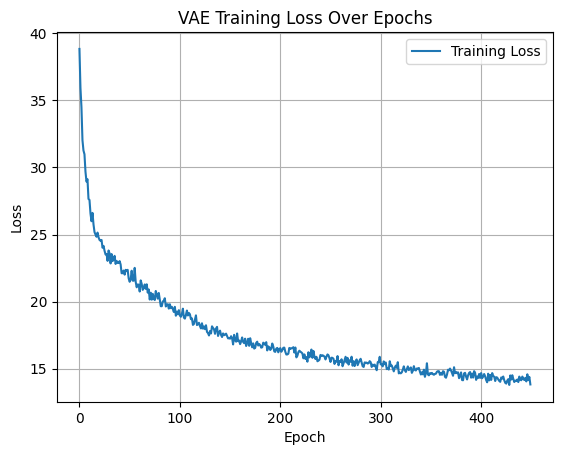


Generating 2400 fake samples...

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Real dysgraphia percentage: 47.5000%
(2400, 22) (2400,)
        sex      hand        age             1             2             3  \
0  0.645746  0.823089  13.117671  45629.142514   9578.699905  25035.017740   
1  0.705777  0.919675  11.337415  46344.494485  10166.625077  25278.948274   
2  0.583050  0.908832  12.473554  39481.692448  10954.155341  21969.996274   
3  0.654196  1.022222  12.104169  43122.255220  10607.161326  24116.493560   
4  0.845501  1.084849  11.328212  48382.757856  10424.176038  26182.223385   

              4            5             6            7  ...           10  \
0  23771.225601  9158.951375  34850.569353  6205.901712  ...  7686.183333   
1  23546.439928  9130.828326  34989.892584  5903.030835  ...  8126.392919   
2  20413.675136  7309.677963  35553.860135  6637.068876  ...  8697.613817   
3  22644.332271  8060.489203  34176.528262  5213.536680  ...  8023.605963   
4  24764.296499 

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVC
import keras.ops as K
##################################
####### PARAMS TO TUNE ###########
SHA = True # try False
ratioFakeToReal = 20 # 20:1 ratio of fake to real
latent_dim = 8 # 5 was good TODO can TWEAK but has to be << ~22
##################################

np.random.seed(42)
keras.utils.set_random_seed(42)


print(f"Using SHA (sex hand age): {SHA}")
if SHA:
    X_real = X.copy()
else:
    X_real = X_no_sex_hand_age.copy()
y_real = y.copy()

# Normalize
X_real_norm = (X_real - X_real.mean()) / X_real.std()

# Simple VAE as a custom model
n_features = X_real.shape[1]  # ~20


class VAE(keras.Model):
    def __init__(self, n_features, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder_inputs = layers.Input(shape=(n_features,))
        x = layers.Dense(16, activation='relu')(self.encoder_inputs)
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)

        # Sampling
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = keras.backend.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        self.z = layers.Lambda(sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        # Decoder
        self.decoder_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(16, activation='relu')(self.decoder_inputs)
        self.decoder_outputs = layers.Dense(n_features, activation='linear')(x)

        # Define submodels
        self.encoder = keras.Model(self.encoder_inputs, [self.z_mean, self.z_log_var, self.z], name='encoder')
        self.decoder = keras.Model(self.decoder_inputs, self.decoder_outputs, name='decoder')

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Compute losses
        reconstruction_loss = K.mean(K.square(inputs - reconstructed)) * n_features
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstructed

# Instantiate and compile
vae = VAE(n_features, latent_dim)
vae.compile(optimizer='adam')

# Print model summary
print("VAE Model Summary:")
vae.summary()

# Train VAE
#vae.fit(X_real_norm, epochs=50, batch_size=32, verbose=0)
###################
history = vae.fit(X_real_norm, epochs=450, batch_size=32, verbose=0)  # verbose=1 to see progress

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('VAE Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

###################



# Generate fake X
n_samples = X_real.shape[0]*ratioFakeToReal
print(f"\nGenerating {n_samples} fake samples...\n")
z_sample = np.random.normal(0, 1, (n_samples, latent_dim))
X_fake_norm = vae.decoder.predict(z_sample)
X_fake = X_fake_norm * X_real.std().values + X_real.mean().values

# Train SVM on real data
svm = SVC(probability=True, random_state=42)
svm.fit(X_real_norm, y_real)

# Predict y_fake
X_fake_norm_df = pd.DataFrame(X_fake_norm, columns=X_real.columns)
y_fake_probs = svm.predict_proba(X_fake_norm_df)[:, 1]  # Probability of class 1 (dysgraphia)

# Adjust threshold to match real data's ~47.5% dysgraphia rate
print(f"Real dysgraphia percentage: {100*realDysgraphiaPercentage:.4f}%")
target_mean = realDysgraphiaPercentage
threshold = np.percentile(y_fake_probs, 100 * (1 - target_mean))  # ~52.5th percentile
y_fake = (y_fake_probs >= threshold).astype(int)

# Convert to DataFrame
X_fake_df = pd.DataFrame(X_fake, columns=X_real.columns)
y_fake_series = pd.Series(y_fake, name='dysgraphia')

# Preview
print(X_fake_df.shape, y_fake_series.shape)
print(X_fake_df.head())
print(y_fake_series.head())
print(f"Mean of y_fake (dysgraphia rate): {y_fake_series.mean()*100:.4f}%")


## Deep NN for binary Classification

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

def train_nn(X, y, model_name="NN"):
    n_features = X.shape[1]
    ###############
    patience = 5 # 5 is good
    ###############
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Define model (unchanged)
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train on full data (unchanged)
    history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    loss, accuracy = model.evaluate(X, y, verbose=0)
    print(f"{model_name} - Accuracy on training data: {accuracy:.4f}")
    
    # 10-fold stratified CV, repeated 10 times JUST LIKE RESEARCH PAPER
    """
    Classifier validation was conducted using stratified tenfold cross-validation,
    and the whole process was repeated ten times. 
    Classification accuracy, sensitivity, and specificity over the ten repetitions were averaged.
    """
    n_folds = 10
    n_repeats = 10
    all_cv_scores = []
    
    for repeat in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42 + repeat)  # Vary seed per repeat
        cv_scores = []
        for train_idx, val_idx in kf.split(X, y):  # Pass y for stratification
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            cv_model = keras.Sequential([
                layers.Input(shape=(n_features,)),
                layers.Dense(16, activation='relu'),
                layers.Dense(8, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ])
            cv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            cv_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])
            _, fold_accuracy = cv_model.evaluate(X_val, y_val, verbose=0)
            cv_scores.append(fold_accuracy)
        all_cv_scores.extend(cv_scores)
    
    cv_mean = np.mean(all_cv_scores)
    cv_std = np.std(all_cv_scores)
    print(f"{model_name} - Cross-validation accuracy: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
    
    # Plot loss (unchanged)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, history
    
# Scenario 1: Train on real data only
print("Training on Real Data Only")
model_real, history_real = train_nn(X_real, y_real, "Real Data NN")

# Scenario 2: Train on fake data only
print("\nTraining on Fake Data Only")
model_fake, history_fake = train_nn(X_fake_df, y_fake_series, "Fake Data NN")

# Scenario 3: Train on combined real + fake data
X_combined = pd.concat([X_real, X_fake_df], axis=0)
y_combined = pd.concat([y_real, y_fake_series], axis=0)
print("\nTraining on Combined Real + Fake Data")
model_combined, history_combined = train_nn(X_combined, y_combined, "Combined Data NN")

In [ ]:
#####################
print(
    """
    We notice that the performance of the real+fake NN is slightly better than the best shallow ML approaches tried before,
    meaning that the synthetic data generation and use of deep NN successfully improved performance! :)
    We notice that the NN trained on real+fake data outperforms the ones trained on only real and only fake (only fake is pretty close).
    We expect the deep NN trained on only real data to have very poor accuracy, since there is not enough data to train it. It is because of this that we used shallow ML techniques before.
    """
)

In [ ]:
##################################################

In [ ]:
#########################################################################

## Clustering

In this section, we shift from summarizing handwriting time series (x, y coordinates, penDown status, timestamps) into static feature vectors (e.g., mean, std) to leveraging the full sequential data for dysgraphia detection. Previously, reducing each user’s text to a single vector lost temporal dynamics critical for identifying dysgraphia-related patterns. Now, we aim to analyze the entire time series to automatically detect specific handwriting strokes associated with dysgraphia. The approach involves:

Segmentation: Segment the time series into strokes (e.g., where penDown changes from 0 to 1 or vice versa) and cluster those to focus on stroke-level patterns.

Clustering: Apply the K-medoids algorithm with Dynamic Time Warping (DTW) as the dissimilarity measure, capturing sequential similarities in handwriting.

Goal: Identify homogeneous clusters of strokes (subtext) rather than whole texts, as smaller segments are more likely to reveal dysgraphia-specific irregularities (e.g., jerky or hesitant strokes) than clustering entire texts.

This method preserves temporal information, targets dysgraphia at the stroke level, and uses robust clustering to handle variable-length sequences, offering a more detailed and biologically relevant analysis than static summaries.


In [ ]:
#!pwd
#!cd dataSciRep_public

In [31]:
#!pip install tqdm
from tqdm import tqdm

In [32]:
# now we read the data2_SciRep_pub.xlsx file which contains these columns:
# userid, diagnosis (dysgraphia or not), sex, hand (right or left), age

xlsx_df = pd.read_excel('../data2_SciRep_pub.xlsx')
#xlsx_df = xlsx_df.iloc[:, :-2] # for some reason we end up with two additional columns with NaN values, which we drop
# we must convert diag, sex, hand to binary features, 0 and 1
xlsx_df['diag'] = xlsx_df['diag'].replace({'DYSGR': 1})
# ONLY KEEP ID AND DIAG COLUMNS
xlsx_df = xlsx_df[['ID', 'diag']]
xlsx_df

,ID,diag
0,6,1
1,7,1
2,8,1
3,11,1
4,13,1
...,...,...
115,187,0
116,189,0
117,190,0
118,191,0


In [33]:
print("HI")

HI


In [34]:
# Segment into strokes based on penDown transitions
#only tracks strokes when the pen is down (penDown=1),
#treating those as active writing segments,
#and ignores data when the pen is up (penDown=0), since no stroke is recorded during those periods
current_dir = os.getcwd()

all_strokes = []
metadata = []  # list for user_id and diag for each stroke

#metadata[i] contains the user_id and diag of all_strokes[i]

i = 0

keep_columns = ['x', 'y', 'timestamp', '?', '??', 'pressure']  # Exclude penDown, since each loop contains only rows where penDown=1

for item in tqdm(os.listdir(current_dir), desc="Processing users"):
    if os.path.isdir(os.path.join(current_dir, item)):
        uid = item[-5:]
        file_path = f"{item}/session00001/u{uid}s00001_hw00001.svc"
        
        df = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
        df.columns = column_names
        
        strokes = []
        current_stroke = []
        for idx, row in df.iterrows():
            if idx == 0:
                if row['penDown'] == 1:
                    current_stroke.append(row[keep_columns])  # Drop penDown here
            else:
                prev_pen_down = df.iloc[idx - 1]['penDown']
                curr_pen_down = row['penDown']
                if prev_pen_down == 0 and curr_pen_down == 1:
                    current_stroke = [row[keep_columns]]  # Drop penDown here
                elif prev_pen_down == 1 and curr_pen_down == 0:
                    if current_stroke:
                        stroke_df = pd.DataFrame(current_stroke, columns=keep_columns)
                        stroke_df.reset_index(drop=True, inplace=True)  # Reset index here
                        strokes.append(stroke_df)
                        current_stroke = []
                elif curr_pen_down == 1:
                    current_stroke.append(row[keep_columns])  # Drop penDown here
        
        if current_stroke:
            stroke_df = pd.DataFrame(current_stroke, columns=keep_columns)
            stroke_df.reset_index(drop=True, inplace=True)  # Reset index for final stroke
            strokes.append(stroke_df)

        diag = xlsx_df[xlsx_df['ID'] == int(uid)]['diag'].values[0]  # Get diagnosis for this user
        for stroke_df in strokes:
            all_strokes.append(stroke_df)
            metadata.append({'user_id': uid, 'diag': diag})  # One entry per stroke
        
        i += 1

print(f"Processed {i} users")
print(f"Total strokes extracted: {len(all_strokes)}")
assert len(all_strokes)==len(metadata)
assert i == 120, f"Expected 120 users, got {i}"

Processing users: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 120/120 [03:19<00:00,  1.66s/it]

Processed 120 users
Total strokes extracted: 7628


In [35]:
i=-1
print(all_strokes[i])
print(metadata[i])

        x     y  timestamp     ?   ??  pressure
0   38564  6592  170527013  1740  650       396
1   38567  6598  170527021  1760  640       534
2   38569  6607  170527028  1760  640       608
3   38572  6616  170527036  1760  630       677
4   38574  6623  170527043  1780  630       756
5   38576  6626  170527051  1780  630       807
6   38577  6626  170527058  1780  630       850
7   38577  6626  170527066  1800  620       886
8   38579  6626  170527073  1800  620       915
9   38580  6626  170527081  1800  620       937
10  38582  6626  170527088  1800  610       955
11  38585  6624  170527096  1800  610       973
12  38587  6621  170527103  1800  610       989
13  38590  6619  170527111  1800  600      1001
14  38593  6618  170527118  1800  600      1012
15  38595  6618  170527126  1800  600      1023
16  38597  6618  170527133  1820  600      1023
17  38598  6618  170527141  1820  590      1023
18  38598  6618  170527148  1820  590      1023
19  38599  6618  170527156  1820  590   

In [36]:
def plot_stroke(all_strokes, i, title="Stroke Plot"):
    """
    Plots the x and y coordinates of a stroke.
    """
    stroke_df = all_strokes[i]
    plt.figure(figsize=(8, 6))
    plt.plot(stroke_df['x'], stroke_df['y'], marker='o', markersize=2, linestyle='-', color='b')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f"{title} (User {metadata[i]['user_id']} with Diag: {metadata[i]['diag']})")
    plt.grid(True)
    plt.show()

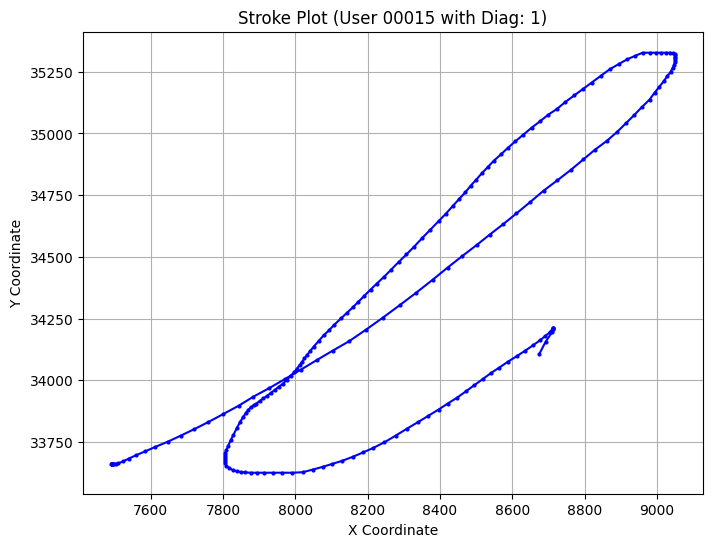

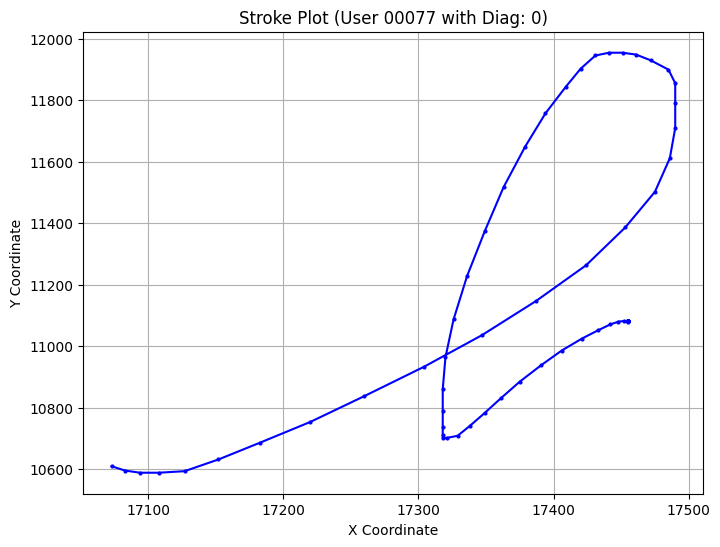

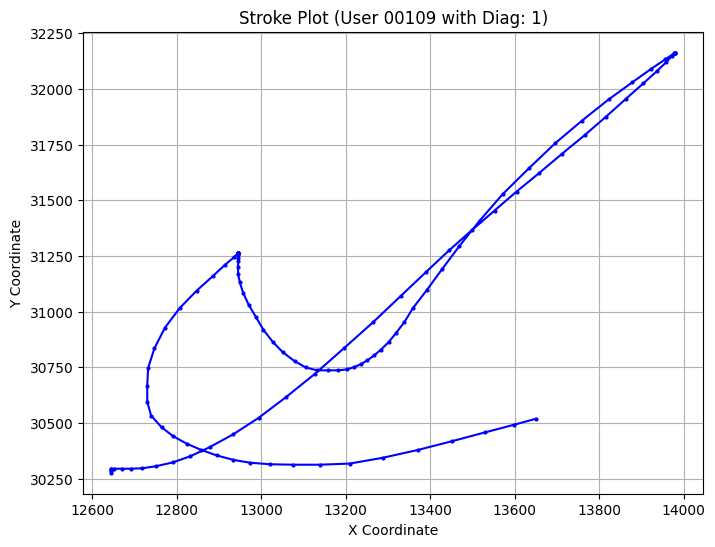

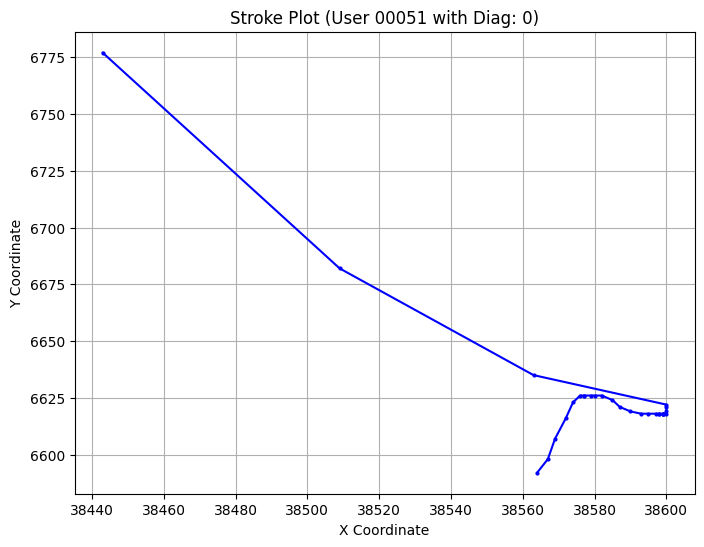

In [37]:
for i in [0, 100, 5000, -1]: # plot a few strokes
    plot_stroke(all_strokes, i)

In [38]:
####################################
####### FOR TESTING, SO REMOVE #####
#max_num_strokes = 500
#all_strokes = all_strokes[:max_num_strokes]
#metadata = metadata[:max_num_strokes]
####################################


In [39]:
print(len(all_strokes))


7628


In [40]:
"""
we need to do clustering not on all strokes, but on a subset (training data) of all strokes,
and do cross validation 
the "model" would need to take a new stroke and idtenify which cluster it belongs to and the dysgraphia percentage of that clsuter is the diagnosis. 
when a user gives multiple strokes to the algorithm, then this is averaged across all strokes
"""

'\nwe need to do clustering not on all strokes, but on a subset (training data) of all strokes,\nand do cross validation \nthe "model" would need to take a new stroke and idtenify which cluster it belongs to and the dysgraphia percentage of that clsuter is the diagnosis. \nwhen a user gives multiple strokes to the algorithm, then this is averaged across all strokes\n'

In [41]:
print(metadata[-1])

{'user_id': '00051', 'diag': '0'}


In [42]:
#!pip install dtaidistance
#%cd dataSciRep_public
!pwd

/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia/dataSciRep_public


In [43]:
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import dtw
from sklearn.model_selection import train_test_split, RepeatedKFold

########################
n_clusters = 15  # TODO: Tweak if needed

########################


# Prepare stroke data
stroke_sequences = [stroke_df.values for stroke_df in all_strokes]
total_n_strokes = len(stroke_sequences)
print(f"Total number of strokes: {total_n_strokes}")


"""
this segments strokes at the stroke level and not at the user level :(
# Split into train and test
train_strokes, test_strokes, train_meta, test_meta = train_test_split(
    all_strokes, metadata, test_size=0.3, random_state=42
)
"""
# Split into train and test by user_id to ensure all strokes of a user are in the same split
#unique_users = metadata['user_id'].unique()
user_ids = [m['user_id'] for m in metadata]
unique_users = np.unique(user_ids)
test_users = np.random.choice(unique_users, size=int(0.3 * len(unique_users)), replace=False)

# Split the data
train_strokes = []
test_strokes = []
train_meta = []
test_meta = []

for stroke, meta in zip(all_strokes, metadata):
    if meta['user_id'] in test_users:
        test_strokes.append(stroke)
        test_meta.append(meta)
    else:
        train_strokes.append(stroke)
        train_meta.append(meta)


#train_meta = pd.DataFrame(train_meta).reset_index(drop=True)
#test_meta = pd.DataFrame(test_meta).reset_index(drop=True)
train_sequences = [stroke_df.values for stroke_df in train_strokes]
n_train = len(train_sequences)
print(f"Training strokes: {n_train}, Test strokes: {len(test_strokes)}")

# Prediction function
def predict_dysgraphia(strokes, medoids, cluster_summary):
    proportions = []
    for stroke in strokes:
        distances = [dtw(stroke, medoid) for medoid in medoids]  # Stroke is already a NumPy array
        cluster = np.argmin(distances)
        proportions.append(cluster_summary[cluster]['dysgraphia_proportion'])
    return np.mean(proportions) if proportions else 0



Total number of strokes: 7628
Training strokes: 5403, Test strokes: 2225


In [ ]:
# 10-fold CV repeated 5 times
n_repeats=1#5
n_splits=10
n_folds=n_splits*n_repeats
print(f"Running {n_repeats} repeats of 10-fold CV")
rkf = RepeatedKFold(n_splits=10, n_repeats=n_repeats, random_state=42)
cv_results = []
continuous_accuracies = []

for fold, (train_idx, val_idx) in enumerate(rkf.split(train_sequences)):
    fold_train_seq = [train_sequences[i] for i in train_idx]
    fold_val_seq = [train_sequences[i] for i in val_idx]
    fold_train_meta = [train_meta[i] for i in train_idx]
    fold_val_meta = [train_meta[i] for i in val_idx]

    # Compute distance matrix for fold training data
    n_fold_train = len(fold_train_seq)
    distance_matrix_file = f"../distance_matrices/distance_matrix_fold_{fold}_{n_fold_train}.npy"
    if os.path.exists(distance_matrix_file):
        distance_matrix = np.load(distance_matrix_file)
        #print(f"Fold {fold+1}/50: Loaded distance matrix from {distance_matrix_file}")
    else:
        distance_matrix = np.zeros((n_fold_train, n_fold_train))
        for i in tqdm(range(n_fold_train), desc=f"Fold {fold+1}/{n_folds}"):
            for j in range(i + 1, n_fold_train):
                dist = dtw(fold_train_seq[i], fold_train_seq[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
        np.save(distance_matrix_file, distance_matrix)
        #print(f"Fold {fold+1}/50: Saved distance matrix to {distance_matrix_file}")

    # Cluster
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42)
    cluster_labels = kmedoids.fit_predict(distance_matrix)

    # Cluster summary
    cluster_summary = {}
    for cluster in range(n_clusters):
        cluster_strokes = [m for i, m in enumerate(fold_train_meta) if cluster_labels[i] == cluster]
        n_strokes = len(cluster_strokes)
        n_dysgraphic = sum(1 for m in cluster_strokes if m['diag'] == 1)
        cluster_summary[cluster] = {
            'n_strokes': n_strokes,
            'dysgraphia_proportion': n_dysgraphic / n_strokes if n_strokes > 0 else 0
        }
        #print(f"Fold {fold+1}/50, Cluster {cluster}: {n_strokes} strokes, Dysgraphia: {n_dysgraphic} ({cluster_summary[cluster]['dysgraphia_proportion']:.2%})")

    # Validation prediction
    medoids = [fold_train_seq[i] for i in kmedoids.medoid_indices_]
    val_predictions = [predict_dysgraphia([s], medoids, cluster_summary) for s in fold_val_seq]
    val_true = [m['diag'] for m in fold_val_meta]    
    ca_scores = [1 - abs(p - int(t)) for p, t in zip(val_predictions, val_true)]
    continuous_accuracy = np.mean(ca_scores)
    continuous_accuracies.append(continuous_accuracy)
    print(f"Fold {fold+1}/{n_folds}: Continuous Accuracy = {continuous_accuracy:.2%}")
    cv_results.append((medoids, cluster_summary))


# CV results
mean_ca = np.mean(continuous_accuracies)
std_ca = np.std(continuous_accuracies)
print(f"Average CV Continuous Accuracy: {mean_ca:.2%} (±{std_ca:.2%})")



In [44]:
# Final model on full training data for prediction of new data
distance_matrix_file = f"../distance_matrices/distance_matrix_train_{n_train}.npy"
if os.path.exists(distance_matrix_file):
    distance_matrix = np.load(distance_matrix_file)
    print(f"Loaded final training distance matrix from {distance_matrix_file}")
else:
    distance_matrix = np.zeros((n_train, n_train))
    for i in tqdm(range(n_train), desc="Final Training"):
        for j in range(i + 1, n_train):
            dist = dtw(train_sequences[i], train_sequences[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    np.save(distance_matrix_file, distance_matrix)
    print(f"Saved final training distance matrix to {distance_matrix_file}")

kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42)
cluster_labels = kmedoids.fit_predict(distance_matrix)
final_medoids = [train_sequences[i] for i in kmedoids.medoid_indices_]
final_cluster_summary = {}
for cluster in range(n_clusters):
    cluster_strokes = [m for i, m in enumerate(train_meta) if cluster_labels[i] == cluster]
    n_strokes = len(cluster_strokes)
    n_dysgraphic = sum(1 for m in cluster_strokes if m['diag'] == 1)
    final_cluster_summary[cluster] = {
        'n_strokes': n_strokes,
        'dysgraphia_proportion': n_dysgraphic / n_strokes if n_strokes > 0 else 0
    }
    print(f"Final Cluster {cluster}: {n_strokes} strokes, Dysgraphia: {n_dysgraphic} ({final_cluster_summary[cluster]['dysgraphia_proportion']:.2%})")

# Test on hold-out set
test_sequences = [stroke_df.values for stroke_df in test_strokes]
test_predictions = [predict_dysgraphia([s], final_medoids, final_cluster_summary) for s in test_sequences]
test_true = [m['diag'] for m in test_meta]
test_ca = np.mean([1 - abs(p - int(t)) for p, t in zip(test_predictions, test_true)])
print(f"Test Continuous Accuracy: {test_ca:.2%}")

Final Training: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5403/5403 [1:18:20<00:00,  1.15it/s]


Saved final training distance matrix to ../distance_matrices/distance_matrix_train_5403.npy
Final Cluster 0: 22 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 1: 1691 strokes, Dysgraphia: 279 (16.50%)
Final Cluster 2: 865 strokes, Dysgraphia: 865 (100.00%)
Final Cluster 3: 58 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 4: 109 strokes, Dysgraphia: 3 (2.75%)
Final Cluster 5: 354 strokes, Dysgraphia: 53 (14.97%)
Final Cluster 6: 71 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 7: 75 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 8: 46 strokes, Dysgraphia: 4 (8.70%)
Final Cluster 9: 287 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 10: 253 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 11: 19 strokes, Dysgraphia: 0 (0.00%)
Final Cluster 12: 367 strokes, Dysgraphia: 85 (23.16%)
Final Cluster 13: 615 strokes, Dysgraphia: 615 (100.00%)
Final Cluster 14: 571 strokes, Dysgraphia: 571 (100.00%)
Test Continuous Accuracy: 87.47%


In [45]:
# Example: User prediction
USERID = '00051'
user_strokes = [s for s, m in zip(all_strokes, metadata) if m['user_id'] == USERID]
user_pred = predict_dysgraphia([s.values for s in user_strokes], final_medoids, final_cluster_summary)
print(f"User {USERID} Dysgraphia Prediction: {user_pred:.2%}")
print(np.mean([int(m['diag']) for m in metadata if m['user_id']==USERID]))

User 00051 Dysgraphia Prediction: 23.16%
0.0


In [46]:

#TODO NEED TO RE RUN WITH DIFFERENT NUMBER OF CLUSTERS, SINCE DISTANCE MATRICES ARE SAVED TO FILE IT WILL BE VERY QUICK THE FOLLOWING TIMES
############## need to maximize CV accuracy and minimize the number of clusters so we do not overfit (minimize enbtropy of each clusters dysgraphia rate)
# --> https://z.imt.fr/service/home/~/?auth=co&loc=fr&id=966&part=2  equations 1 through 4
###################


##########

### Visualization for Interpretabilitt/Reliability

In [47]:
assert len(final_medoids) == n_clusters

Printing all medoids


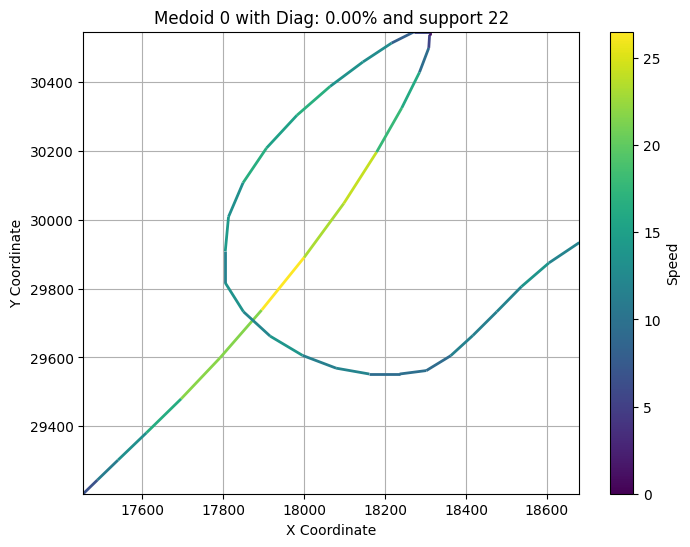

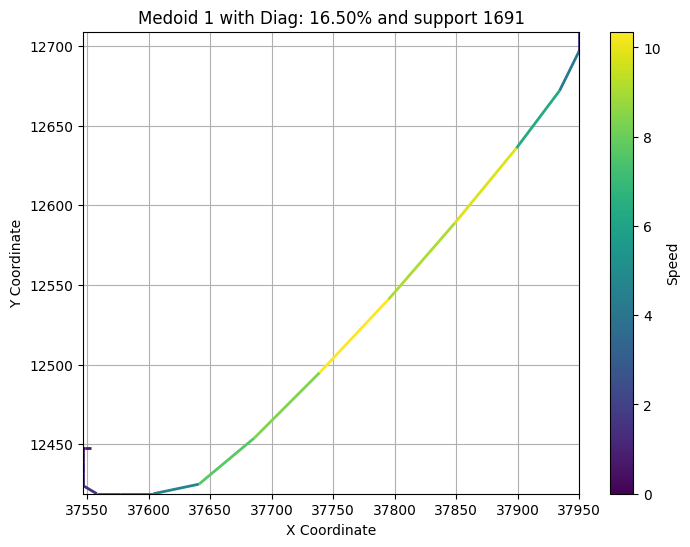

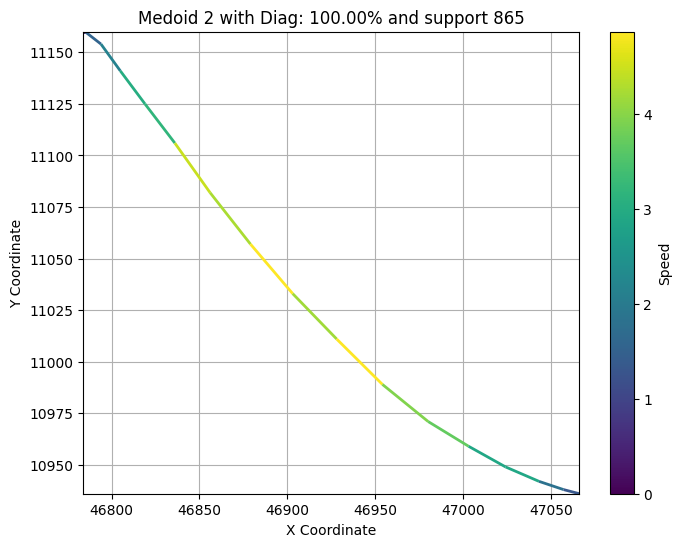

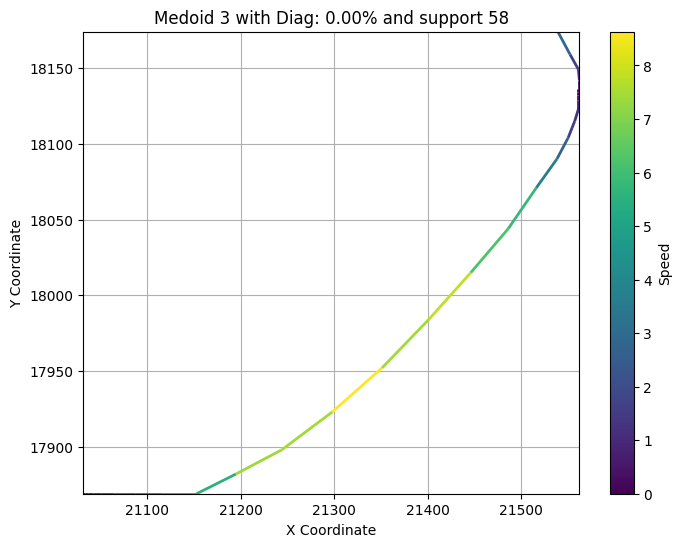

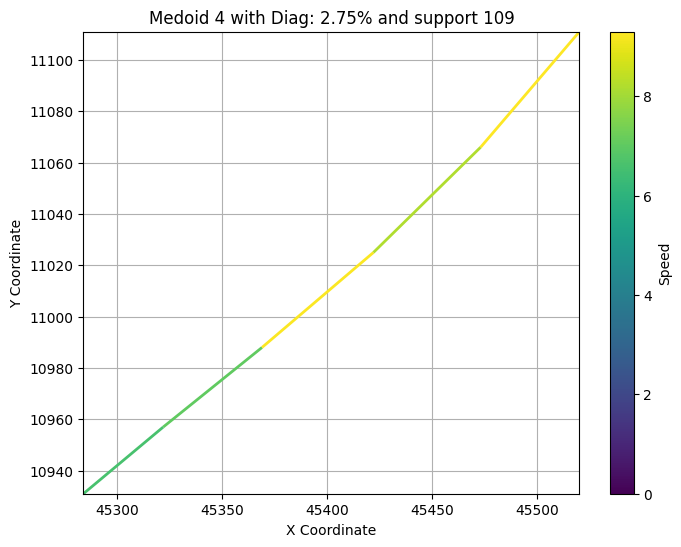

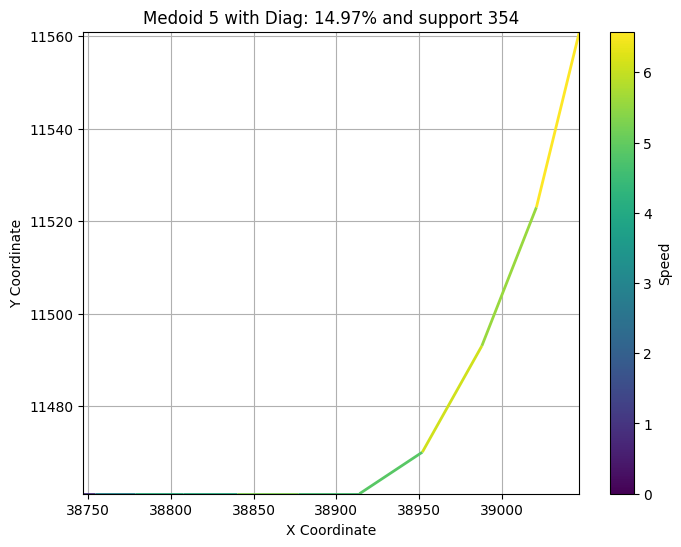

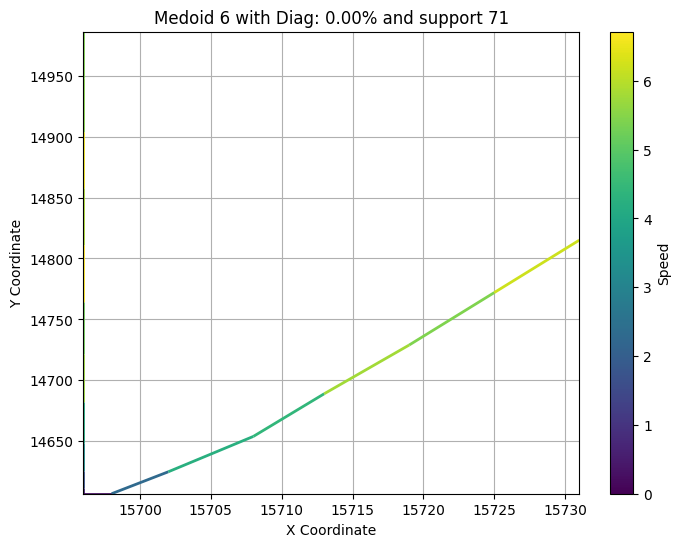

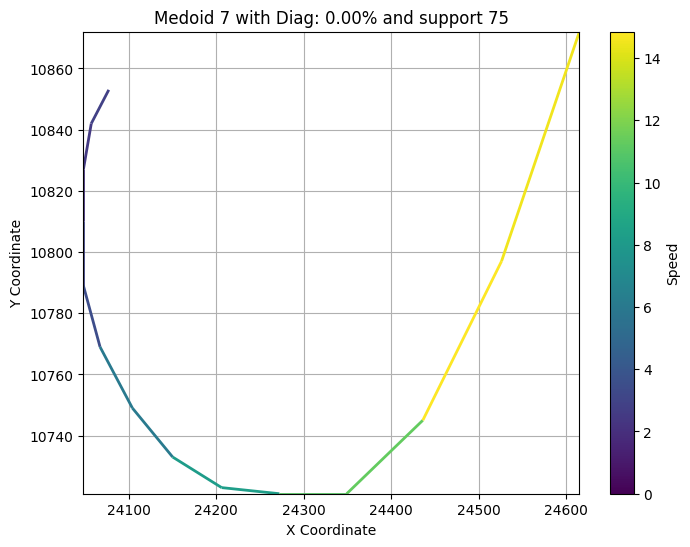

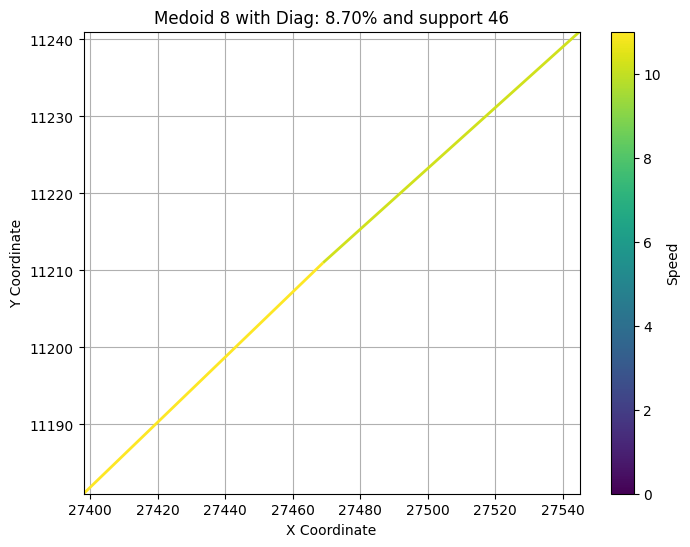

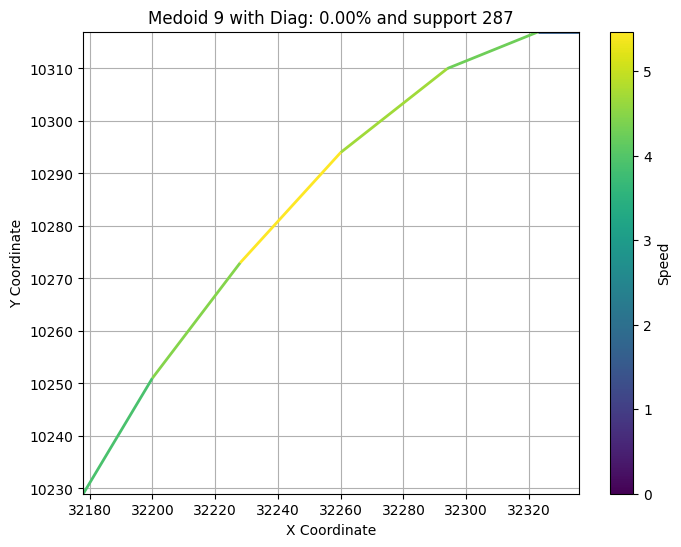

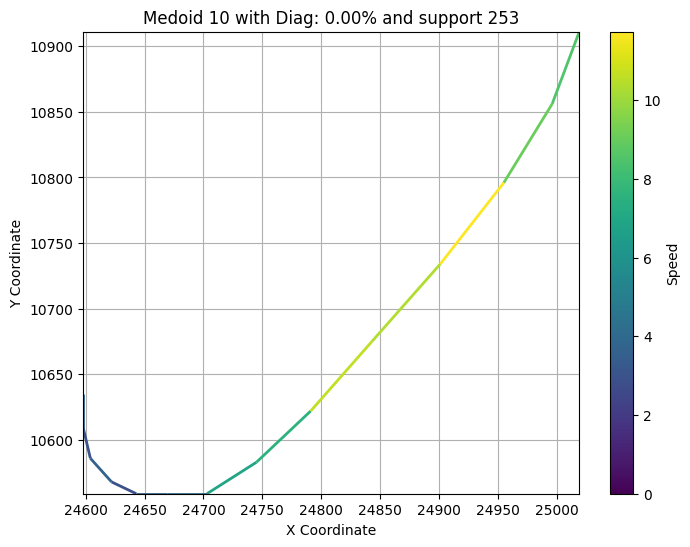

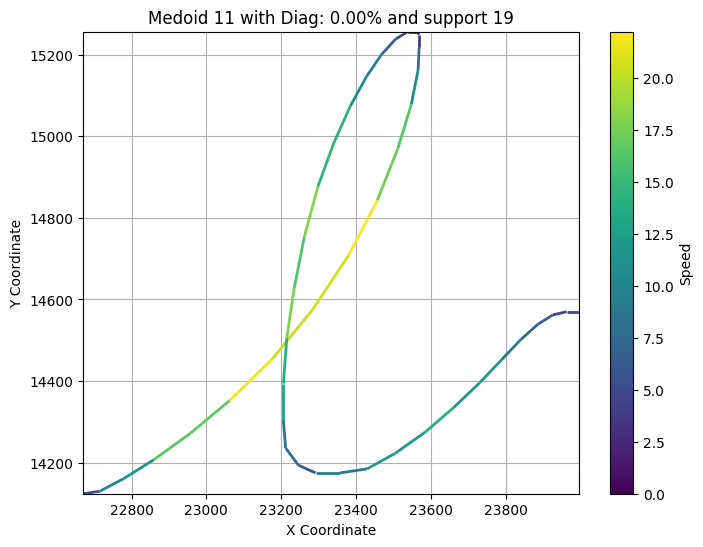

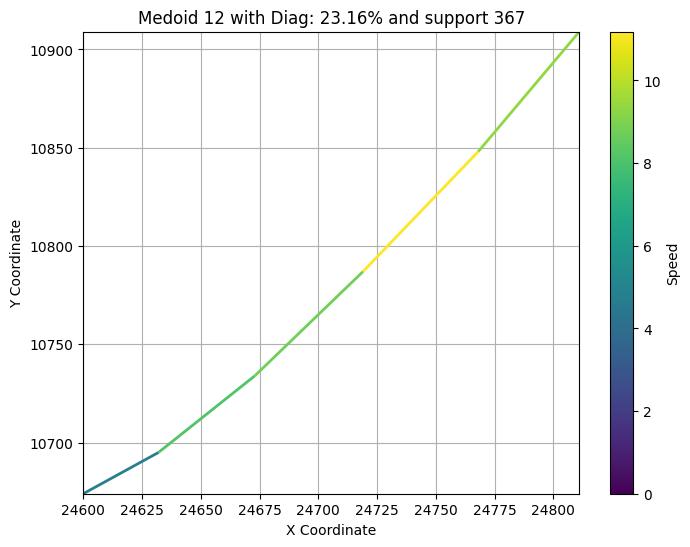

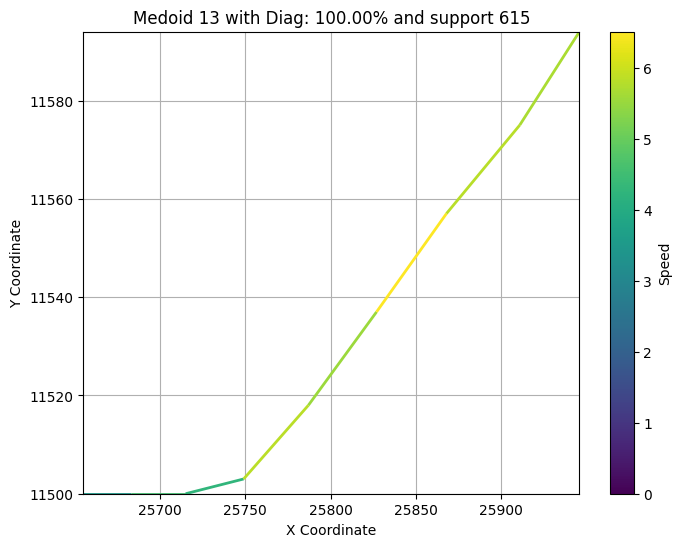

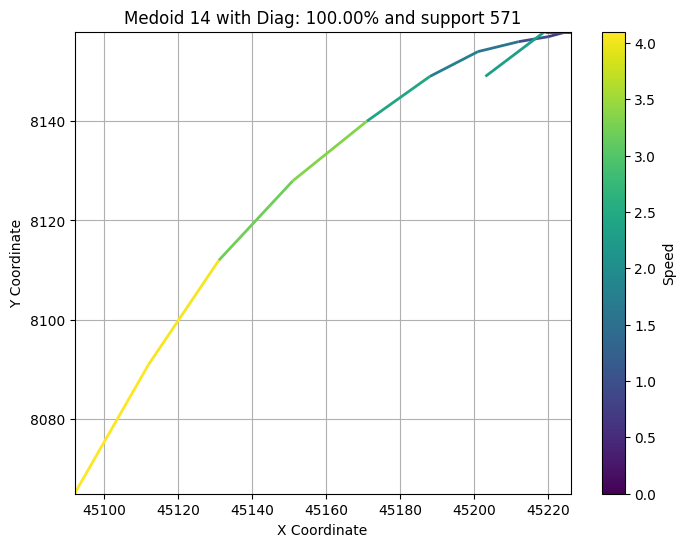

In [48]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

print("Printing all medoids")
for cluster in range(n_clusters):
    stroke_df = pd.DataFrame(final_medoids[cluster], columns=['x', 'y', 'timestamp','b','c','d'])
    
    dx = stroke_df['x'].diff()
    dy = stroke_df['y'].diff()
    dt = stroke_df['timestamp'].diff()
    
    # Avoid division by zero
    speed = np.sqrt(dx**2 + dy**2) / dt.replace(0, np.nan)
    stroke_df['speed'] = speed.fillna(0)
    
    # Get coordinates
    x = stroke_df['x'].values
    y = stroke_df['y'].values
    speed = stroke_df['speed'].values
    
    # Create segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create colored line collection
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(speed.min(), speed.max()))
    lc.set_array(speed[1:])  # skip first nan
    lc.set_linewidth(2)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f"Medoid {cluster} with Diag: {final_cluster_summary[cluster]['dysgraphia_proportion']*100:.2f}% and support {final_cluster_summary[cluster]['n_strokes']}")
    plt.colorbar(lc, label='Speed')
    plt.grid(True)
    plt.show()
    


# BELOW IS TESTING

In [ ]:
##############PCA
#import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt


def perform_pca(X, y, n_components=2):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")
    print(f"Total variance explained: {sum(explained_variance):.3f}")
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Results')
    plt.colorbar(scatter, label='Class (0 or 1)')
    plt.show()
    
    return X_pca, pca



X_transformed, pca_model = perform_pca(X, y)

In [ ]:
"""
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

def perform_pca_3d(X, y, n_components=3):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio per component: {explained_variance}")
    print(f"Total variance explained: {sum(explained_variance):.3f}")
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
    ax.set_xlabel('First PC')
    ax.set_ylabel('Second PC')
    ax.set_zlabel('Third PC')
    ax.set_title('3D PCA Results')
    plt.colorbar(scatter, label='Class (0 or 1)')
    plt.show()
    
    return X_pca, pca

X_transformed, pca_model = perform_pca_3d(X, y)
"""

In [122]:
%cd ..

/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia


/Users/victormicha/PythonProjects/IP_Paris/ResearchProjectDysgraphia/dysgraphia_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [123]:
#%cd ResearchProjectDysgraphia

In [124]:
uid='00014'
file_path = f"dataSciRep_public/user{uid}/session00001/u{uid}s00001_hw00001.svc"
df = pd.read_csv(file_path, 
                 sep='\s+', 
                 skiprows=1, 
                 header=None)
#rename columns
column_names = ['x', 'y', 'timestamp', 'penDown', '?', '??', 'pressure'] 
df.columns = column_names

In [125]:
df

,x,y,timestamp,penDown,?,??,pressure
0,6690,32818,2024961112,1,1130,490,33
1,6689,32818,2024961119,1,1120,490,68
2,6688,32818,2024961127,1,1120,490,89
3,6688,32818,2024961134,1,1120,490,104
4,6688,32818,2024961142,1,1120,490,114
...,...,...,...,...,...,...,...
22081,39682,11565,2025171751,1,1190,580,371
22082,39713,11602,2025171758,1,1200,580,353
22083,39736,11634,2025171766,1,1200,580,327
22084,39751,11663,2025171773,1,1200,580,252


In [126]:
def plot(df, x_column, y_column, penDown=1):

    if penDown:
        df = df[df['penDown'] == 1].copy()

    plt.figure(figsize=(12, 6))
    plt.plot(df[x_column], df[y_column])

    plt.title(f'{y_column} over {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)

    plt.grid(True, linestyle='--', alpha=1)
    
    plt.tight_layout()
    plt.show()


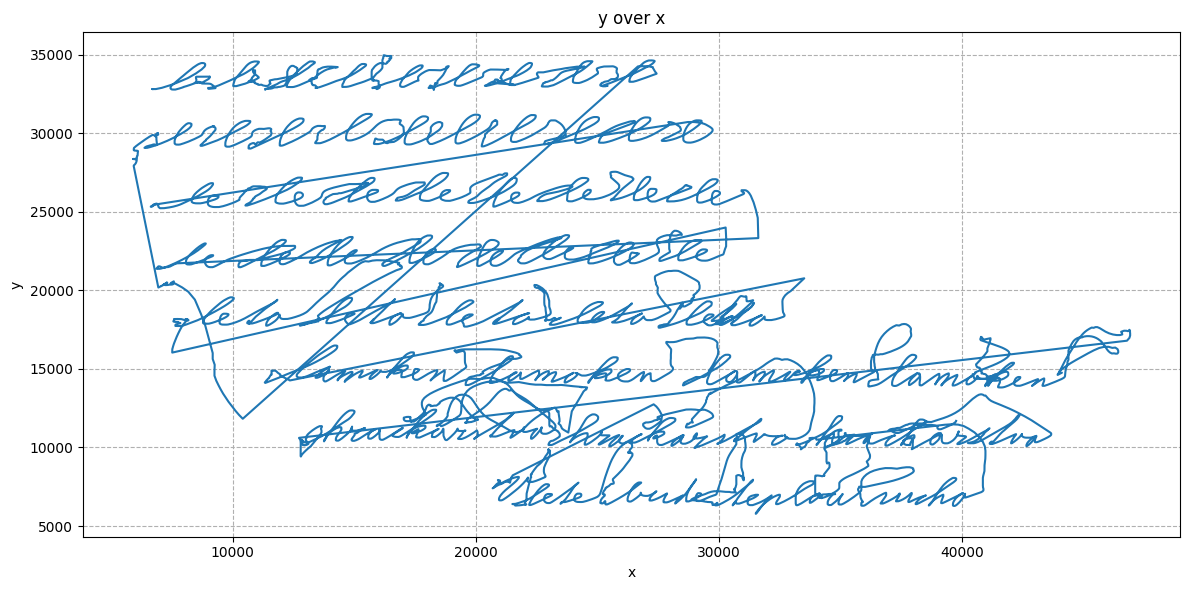

In [127]:
# plot x, y to see what the writing looks like!
plot(df, 'x', 'y', 0)

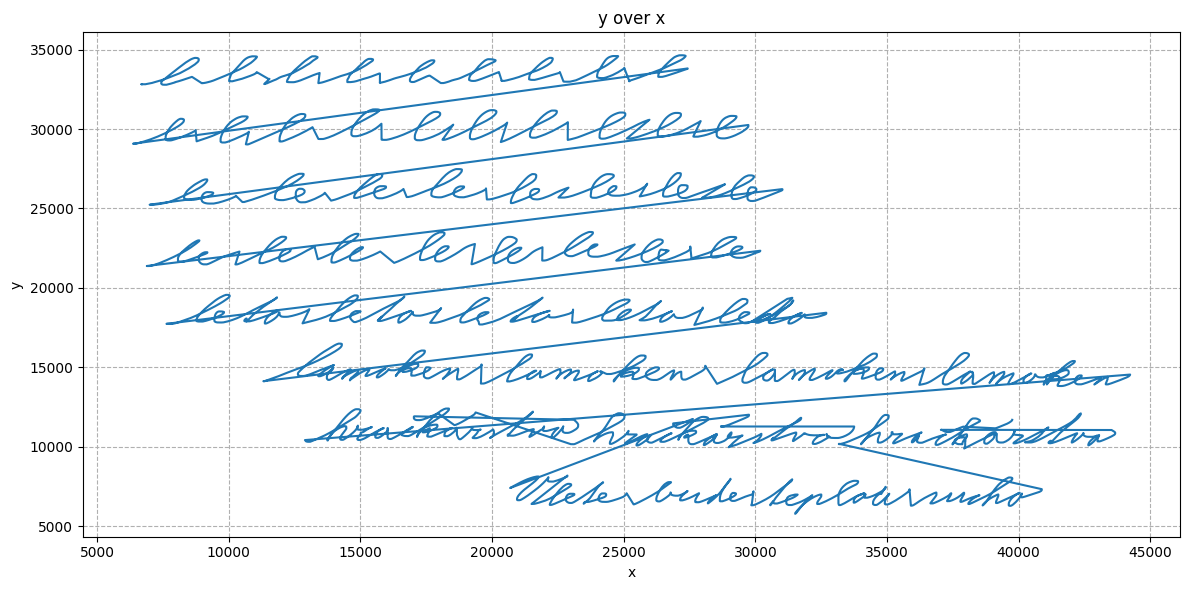

In [128]:
plot(df, 'x', 'y', 1)

In [ ]:
# plot timestamp, other column to see other column over time
plot(df, 'timestamp', 'x',1)

In [ ]:
def get_stats(df, column):
    arr = [
        df[column].max(),
        df[column].min(),
        df[column].mean(),
        df[column].median(),
        df[column].std()
    ]
    return [float(x) for x in arr]

In [ ]:
get_stats(df, 'penDown')

In [ ]:
##########